## This is the first practical task of Sirius summer school "Applying AI for Med image analysis". 
Practical tasks take form of jupyter notebook with example code in the begging and some tasks in the end. Please, provide your solution in form of python code. Read hints, google a lot, don't hesitate to ask us directyl and most importatly - 
<span style="color:blue">have fun</span>.

**Topic**: Data loading and visiualization

**To submit**: New version of the notebook, with your code. 

There are several ways to store data for medical imaging:
- Plain images. (png,jpg)
- DICOM
- NIFTI

Plain images and DICOM are commonly used for 2D data, while Nifti and DICOM are used for 3D data. 

DICOM (Digital Imaging and Communications in Medicine) is the standard for the communication and management of medical imaging information and related data. [ref](https://en.wikipedia.org/wiki/DICOM)

For our purpose DICOM is just fancy container with metadata. 

In [ ]:
#let's install pydicom, which is a library to operate dicom files and their content
!pip install pydicom 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[Pydicom documentation](https://pydicom.github.io/pydicom/stable/)

In [ ]:
import pydicom 
dicom_example = pydicom.read_file("/content/drive/My Drive/Inno/data/IM_00020_ano.dcm")

DICOM holds different kinds of metadata ranging from study details (dose, target area) to patient's personal information. 

In [ ]:
print(dicom_example)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 64
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 144'
(0008, 0008) Image Type                          CS: 'Oxxxxxxxxxxxxxxx'
(0008, 0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Presentation
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.634.0.63963.2019816.94612.23
(0008, 0020) Study Date                          DA: '20190816'
(0008, 0023) Content Date                        DA: '20190816'
(0008, 0030) Study Time                          TM: '094545'
(0008, 0033) Content Time                        TM: '094545'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Mo

The most common vizualization library is matplotlib. It allows to draw images and create complex plots. 

In [ ]:
!pip install matplotlib

Pixel values are stored inside (7fe0, 0010) DICOM tag. We can access it using .pixel_array field
Let's look at our image using matplotlib function .imshow()

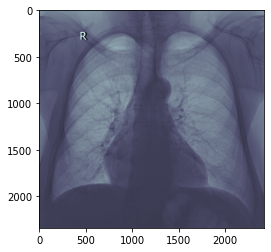

In [ ]:
from matplotlib import pyplot as plt
import matplotlib 

plt.imshow(dicom_example.pixel_array,cmap="bone")

Let's look at histogram of pixel values. 
We will apply plt.hist to "flattened" version of x-ray
https://en.wikipedia.org/wiki/Cumulative_distribution_function
https://en.wikipedia.org/wiki/Histogram


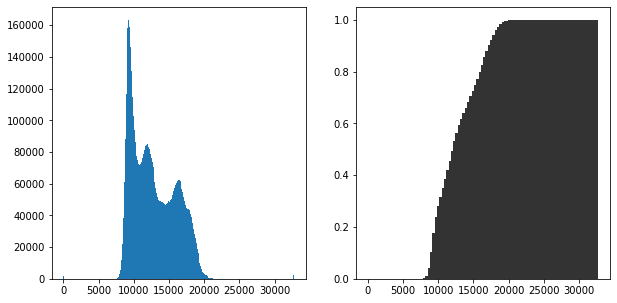

In [ ]:
def create_histogram_and_cdf(dicom):
    """
    Creates histogram and CDF
    """
    fig, (histogram, cdf_plot) = plt.subplots(1, 2,figsize=(10,5))

    histogram.hist(dicom.ravel(),bins=256)
    
    cdf_plot.hist(dicom.ravel(),bins=100, cumulative=True, label='CDF',
         histtype='bar', alpha=0.8, color='k',density=True)
    plt.show()

create_histogram_and_cdf(dicom_example.pixel_array)

#### We see 2 small outliers on left and right side of histogram. Let's drop them and see what happens. 

In [ ]:
img_cpy = dicom_example.pixel_array.copy()
img_cpy[dicom_example.pixel_array == dicom_example.pixel_array.min()] = dicom_example.pixel_array.mean()-dicom_example.pixel_array.std()
img_cpy[dicom_example.pixel_array == dicom_example.pixel_array.max()] = dicom_example.pixel_array.mean()+dicom_example.pixel_array.std()

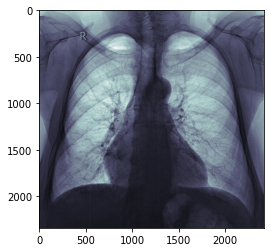

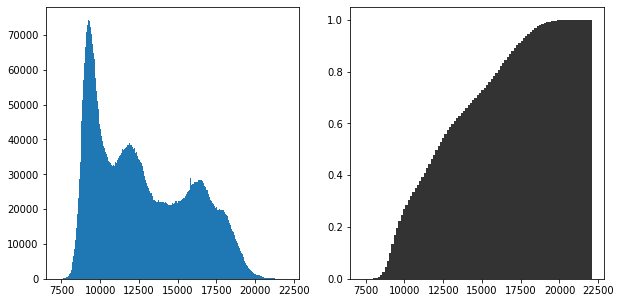

In [ ]:
plt.imshow(img_cpy,cmap="bone")
plt.show()
create_histogram_and_cdf(img_cpy)


### There are a lot of other tricks to manipulate image histogram to make it look nicer. Good slides about image preprocessing: https://docplayer.ru/66503788-Osnovy-obrabotki-izobrazheniy-anton-konushin.html

### Actual values of pixel do not matter, their relative distribution is much more important, hence we can convert our image to proper uint8

Original image maximum 22103
New image maximum 255


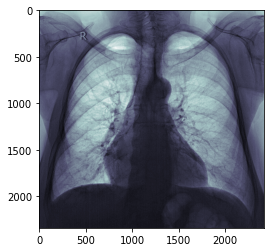

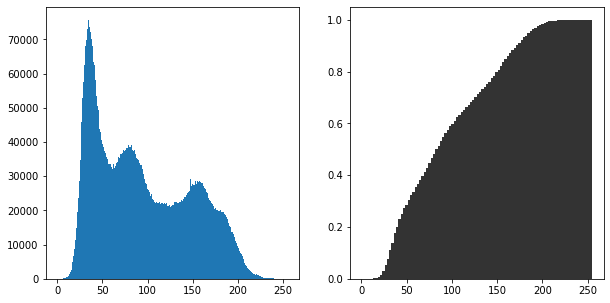

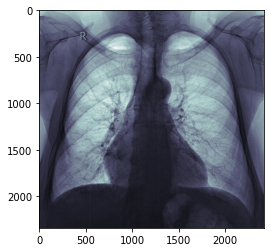

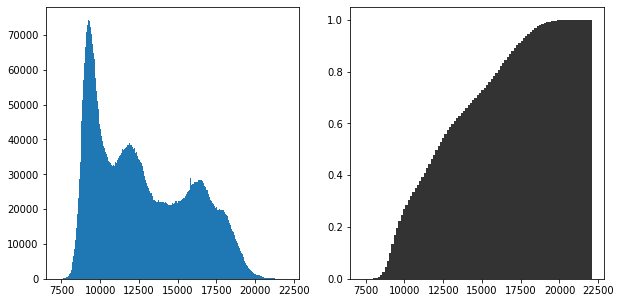

In [ ]:
import numpy as np
img = img_cpy.copy()
img = ((img-img.min()) / (img.max()-img.min()) * 255).astype(np.uint8)
print("Original image maximum {}".format(img_cpy.max()))
print("New image maximum {}".format(img.max()))
plt.imshow(img,cmap="bone")
create_histogram_and_cdf(img)
plt.show()
plt.imshow(img_cpy,cmap="bone")
create_histogram_and_cdf(img_cpy)

##literally the same image


### Functions which transforms colors to new colors is called Color mapping function. In radiology this functions also called LUT (look up table).  
### Radiologists use different LUTs to highlate certain tissue. Let's apply one and see a result. 

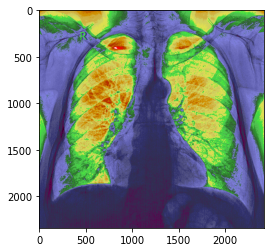

In [ ]:
from pydicom.pixel_data_handlers.util import apply_color_lut
plt.imshow(apply_color_lut(img,palette="PET_20_STEP"),cmap="bone")

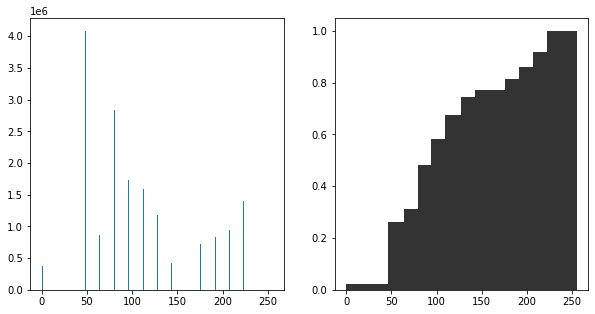

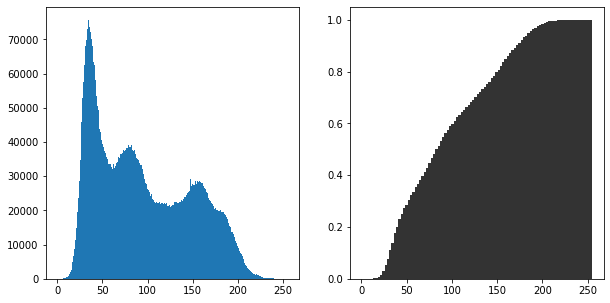

In [ ]:
create_histogram_and_cdf(apply_color_lut(img,palette="PET_20_STEP"))
create_histogram_and_cdf(img)

#### We could call any function f(pixel_array) -> pixel_array LUT. 
#### For example threholding could be seen as particular example of LUT

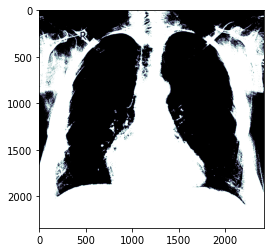

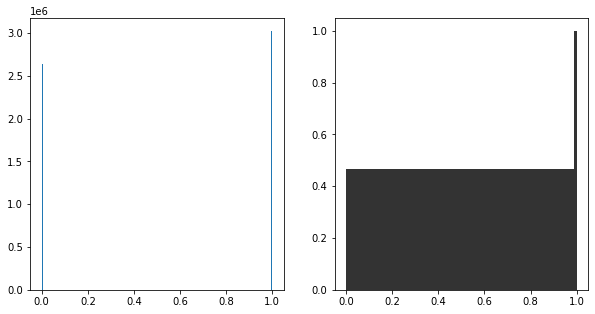

In [ ]:
def thresholding(image):
    return image<90
plt.imshow(thresholding(img),cmap="bone")
create_histogram_and_cdf(thresholding(img).astype(np.uint8))

## **Tasks:**
- Given: img variable with image data in it 
- Do: Think about any function f(img)->new_image. Apply it and visualize the result. 
- Hints: https://pydicom.github.io/pydicom/dev/reference/generated/pydicom.pixel_data_handlers.util.html#pydicom.pixel_data_handlers.util.apply_color_lut


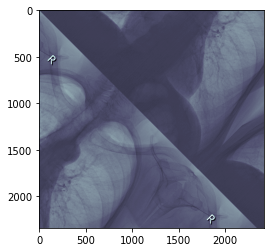

In [ ]:
def f(input):
  """
  Function used to rotate an image by 45 degrees.

  targets: image.
  image types: uint8.
  """
  angle = np.pi/4
  a = np.array([[np.cos(angle), -np.sin(angle)],
              [np.sin(angle), np.cos(angle)]])
  width, height = input.shape
  points = np.mgrid[0:height, 0:width].reshape((2, width*height))
  new_points = np.linalg.inv(a).dot(points).round().astype(int)
  x, y = new_points.reshape((2, width, height), order='F')
  indices = x + height * y
  res = np.take(input, indices, mode='wrap')
  return res

source = dicom_example.pixel_array.copy()
result = f(source)
plt.imshow(result, cmap="bone")

## **Task 2:**
- Sometimes data is broken and your job is to recover useful information
- Given: Data with broken distribution
- Do: Fix distribution any way you see fit and visualize correct x-ray.  



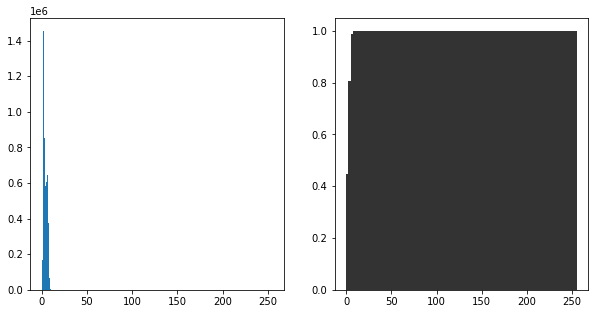

In [ ]:
broken_file = pydicom.read_file("/content/drive/My Drive/Inno/data/broken_file.dcm")
broken_pixel = broken_file.pixel_array
create_histogram_and_cdf(broken_pixel)

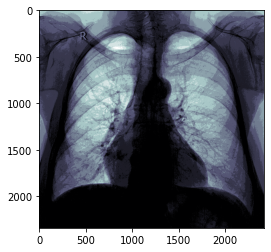

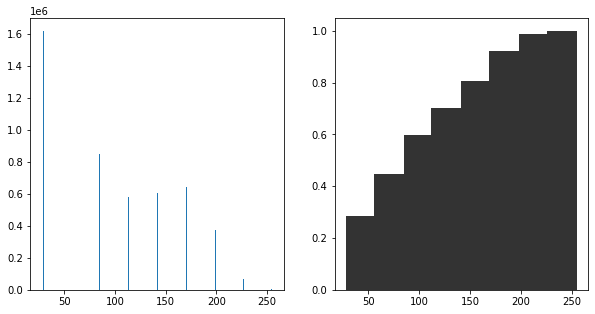

In [ ]:
fixed = broken_pixel.copy()
fixed[broken_pixel == broken_pixel.min()] = broken_pixel.mean()-broken_pixel.std()
fixed[broken_pixel == broken_pixel.max()] = broken_pixel.mean()+broken_pixel.std()
fixed = ((fixed-fixed.min()) / (fixed.max()-fixed.min()) * 255).astype(np.uint8)
fixed += 29
plt.imshow(fixed, cmap="bone")
create_histogram_and_cdf(fixed)